In [148]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [149]:
# TODO:
# - Store timestamps
# - Store constants
#X = np.load('convection.npy')

#X = np.loadtxt('opencl/output.csv', delimiter=';')
X = np.array(pd.read_csv('opencl/output.csv', delimiter=';', header=None))
X = X.reshape(X.shape[0], int(X.shape[1] / 4), 4)
GRAVITY = -10.0

print(X.shape)
dt = 0.001;
T = np.array(range(X.shape[0])) * dt;

# Columns: dissipation, energyFluxLow, energyFluxHigh
C = np.loadtxt('opencl/dissipation.csv', delimiter=';')
print(C.shape)

(20001, 2048, 4)
(20001, 3)


# Dissipation

Text(0.5,1,'Dissipation')

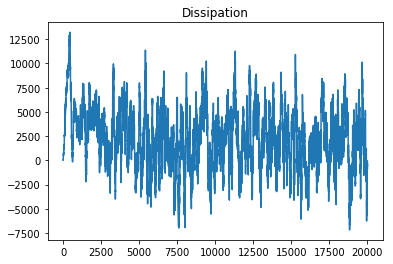

In [150]:
plt.plot(np.convolve(C[:,0], np.ones(100))[:-100])
plt.title('Dissipation')

Text(0.5,1,'EnergyInputLower')

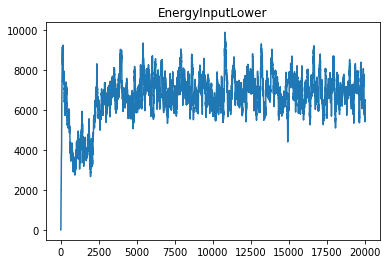

In [151]:
plt.plot(np.convolve(C[:,1], np.ones(100))[:-100])
plt.title('EnergyInputLower')

Text(0.5,1,'EnergyInputUpper')

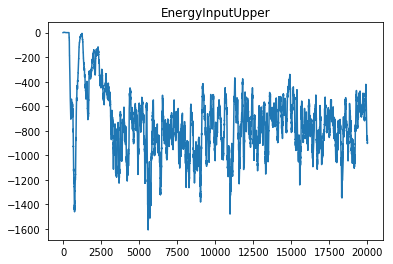

In [152]:
plt.plot(np.convolve(C[:,2], np.ones(100))[:-100])
plt.title('EnergyInputUpper')

Text(0.5,1,'TotalKinetic')

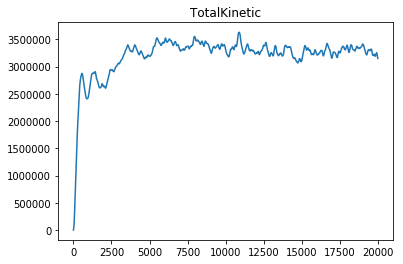

In [153]:
kinetic_energy = 0.5 * np.sum(X[:, :, 2:4] * X[:, :, 2:4], axis=2)
total_kinetic_energy = np.sum(kinetic_energy, axis=1)
plt.plot(np.convolve(total_kinetic_energy, np.ones(100))[:-100])
plt.title('TotalKinetic')

Text(0,0.5,'storage (kinetic)')

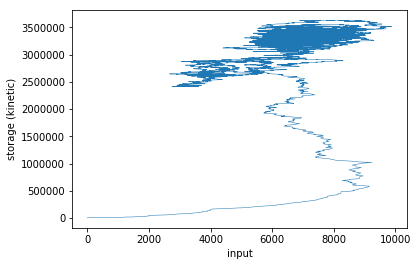

In [154]:
plt.plot(
    np.convolve(C[:,1], np.ones(100))[:-100],
    np.convolve(total_kinetic_energy, np.ones(100))[:-100],
    linewidth=0.5
)
plt.xlabel('input')
plt.ylabel('storage (kinetic)')

Text(0,0.5,'storage (kinetic)')

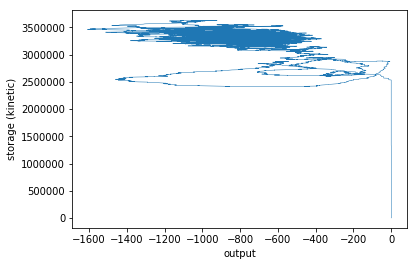

In [155]:
plt.plot(
    np.convolve(C[:,2], np.ones(100))[:-100],
    np.convolve(total_kinetic_energy, np.ones(100))[:-100],
    linewidth=0.5
)
plt.xlabel('output')
plt.ylabel('storage (kinetic)')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0,0.5,'storage (kinetic)')

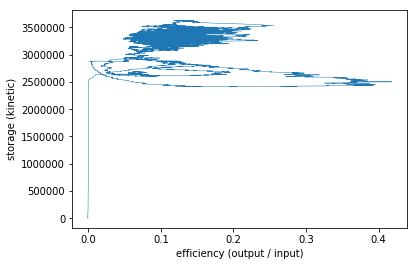

In [156]:
plt.plot(
    np.convolve(-1 * C[:,2], np.ones(100))[:-100] / np.convolve(C[:,1], np.ones(100))[:-100],
    np.convolve(total_kinetic_energy, np.ones(100))[:-100],
    linewidth=0.5
)
plt.xlabel('efficiency (output / input)')
plt.ylabel('storage (kinetic)')

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


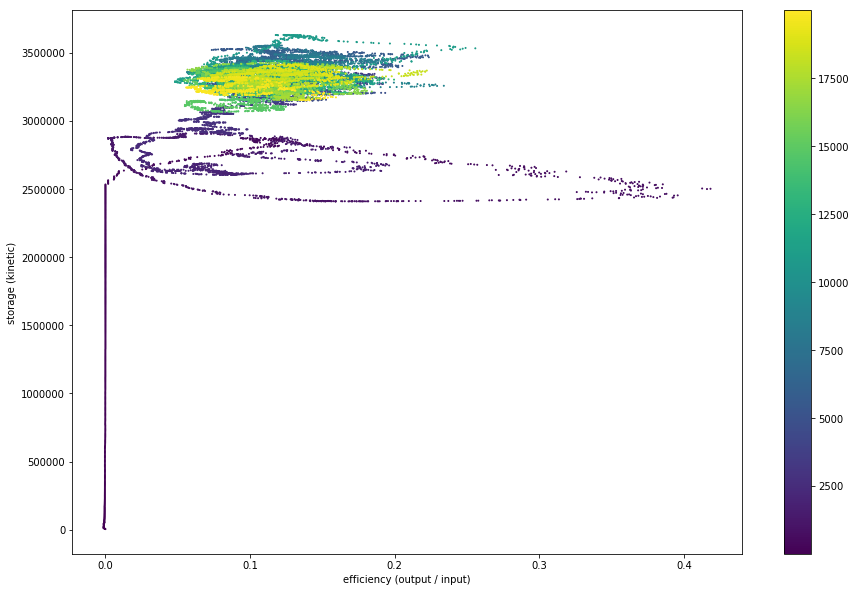

In [157]:
plt.figure(figsize=(15,10))
plt.scatter(
    np.convolve(-1 * C[:,2], np.ones(100))[:-100] / np.convolve(C[:,1], np.ones(100))[:-100],
    np.convolve(total_kinetic_energy, np.ones(100))[:-100],
    c=range(len(np.convolve(total_kinetic_energy, np.ones(100))[:-100])),
    s=1,
)
plt.xlabel('efficiency (output / input)')
plt.ylabel('storage (kinetic)')
plt.colorbar()
#plt.ylim([2e6, plt.ylim()[1]])

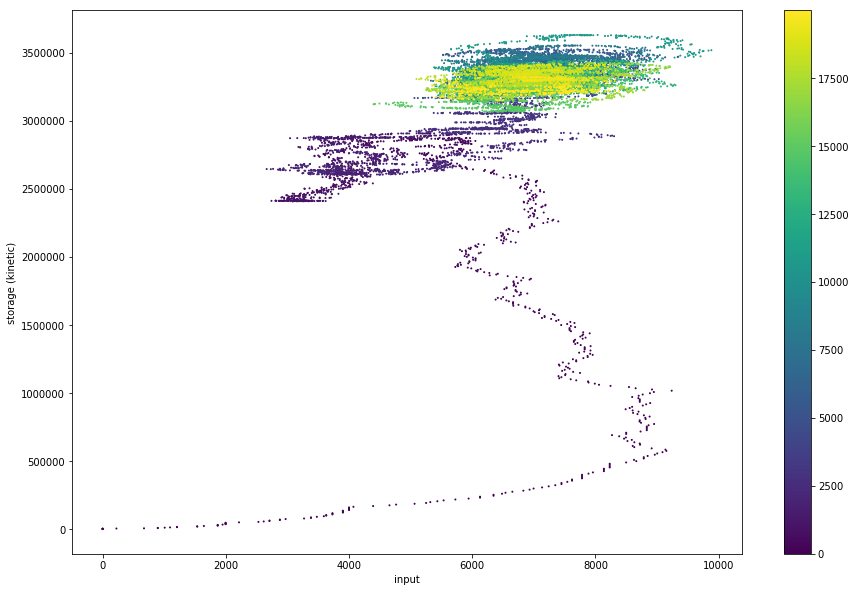

In [169]:
plt.figure(figsize=(15,10))
plt.scatter(
    np.convolve(C[:,1], np.ones(100))[:-100],
    np.convolve(total_kinetic_energy, np.ones(100))[:-100],
    c=range(len(np.convolve(total_kinetic_energy, np.ones(100))[:-100])),
    s=1,
)
plt.xlabel('input')
plt.ylabel('storage (kinetic)')
plt.colorbar()
#plt.ylim([2e6, plt.ylim()[1]])

In [158]:
# It would be great to explain the oscillations around the critical point
# with a state-space equation showing "compatible" modes
# In the economy, or in a metabolism, the input vary (and other things do too).
# I think we're interested in tracking the equilibrium state (i.e. the attractor / fp)
# as it evolves when the input varies.
# If we can find a functional relation, it could be applied elsewhere?

# Motion of particles
- The goal is to find a state-space description for a single particle (or a local blob)
- Another question to answer is: does this exhibit the behavior of a heat engine?

Text(0.5,1,'Motion of particle 0 in (x, y) space')

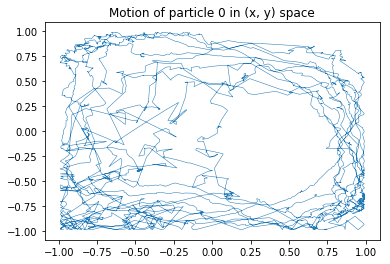

In [159]:
# Here we investigate the motion of one particle in a state space
i = 0
plt.plot(X[:, i, 0], X[:, i, 1], '-', linewidth=0.5)
plt.title(f'Motion of particle {i} in (x, y) space')

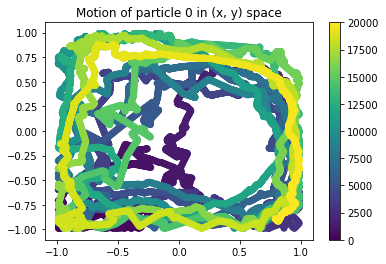

In [181]:
plt.figure()
plt.scatter(X[:, i, 0], X[:, i, 1], c=range(X.shape[0]))
plt.title(f'Motion of particle {i} in (x, y) space')
plt.colorbar();

In [250]:
# First, initialise a small volume square of side dr
dr = 0.25

def local_particles(i, t):
    x = X[t, i, :]
    dx = np.abs(X[t, :, 0] - x[0])
    dy = np.abs(X[t, :, 1] - x[1])
    volume = (  (min([x[0] + dr, 1]) - max([x[0] - dr, -1]))
              * (min([x[1] + dr, 1]) - max([x[1] - dr, -1])))
    return X[t, (dx <= dr) & (dy <= dr), :], volume

# Variable 1: local pressure (energy / volume)
def local_pressure(i, t):
    x, volume = local_particles(i, t)
    v = x[:, (2,3)]
    kinetic_energy = np.linalg.norm(v, axis=1)
    return sum(kinetic_energy) / volume
    
# Variable 2: local temperature (energy / particle)
def local_temperature(i, t):
    x, volume = local_particles(i, t)
    v = x[:, (2,3)]
    kinetic_energy = np.linalg.norm(v, axis=1)
    return sum(kinetic_energy) / len(v)

# Variable 3: local density (particle / volume)
def local_density(i, t):
    x, volume = local_particles(i, t)
    v = x[:, (2,3)]
    return len(v) / volume

# Compute x1 and x2 as the two state variables
P = np.array([local_pressure(i, t) for t in range(X.shape[0])])
T = np.array([local_temperature(i, t) for t in range(X.shape[0])])
D = np.array([local_density(i, t) for t in range(X.shape[0])])

Text(0.5,1,'Motion of particle 0 in local (P, 1/D) space')

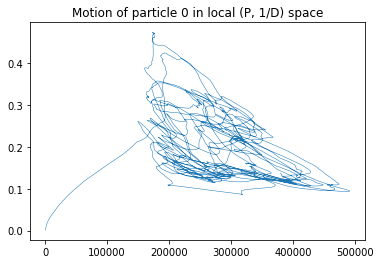

In [251]:
# Here we try to establish if we can see a "Carnot" cycle

#plt.plot(P[-300:], 1/D[-300:], '-', linewidth=0.5)
plt.plot(
    np.convolve(P, np.ones(100))[:-100],
    np.convolve(1/D, np.ones(100))[:-100],
    '-', linewidth=0.5)
plt.title(f'Motion of particle {i} in local (P, 1/D) space')

In [252]:
# It seems like we have thermodynamic cycles that are not "optimal" as they are often far from Carnot
# It's tough to say if there is a convergence towards Carnot cycle over time.
# Some particles do some cycle, but not all the time
# Their efficiency is varying over time
# But many of those "engines" contribute to the overall efficiency of the system
# Local temperatures are what count, and they shouldn't be mixed with the temperature at the edges
#
# In the realworld, a multitude of "engines" (plants, etc..) get the sun's high temperature,
# store it in many forms (fossil fuels etc..), and release it as waste heat.
# Something interesting to investigate is if more complexity yields increased efficiency, but requires
# greater energy input. "complexity" is related to entropy? it is hard to measure though
# Maybe think about how to measure the amount of organisation in the system, and plot over time.
# How far from "random" is it?

Text(0.5,1,'color = temperature')

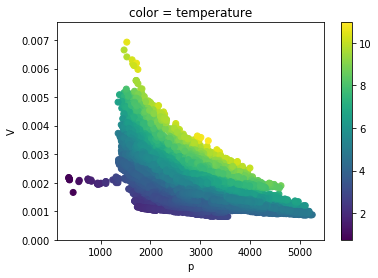

In [253]:
plt.scatter(P, 1/D, c=T);
plt.ylim([0, np.max(1/D) * 1.1]);
plt.xlabel('p');
plt.ylabel('V');
plt.colorbar();
plt.title('color = temperature')

Text(0.5,1,'color = angle')

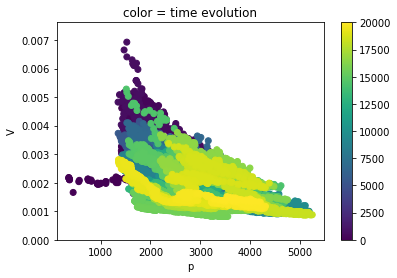

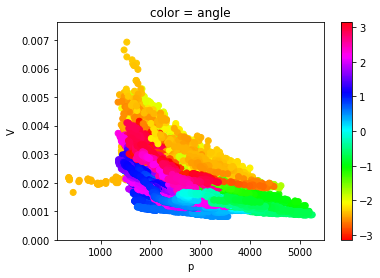

In [254]:
# Plot over time
plt.scatter(P, 1/D, c=range(len(T)));
plt.ylim([0, np.max(1/D) * 1.1]);
plt.xlabel('p');
plt.ylabel('V');
plt.colorbar();
plt.title('color = time evolution')

plt.figure()
plt.scatter(P, 1/D, c=np.arctan2(X[:, i, 1], X[:, i, 0]), cmap=plt.get_cmap('hsv'));
plt.ylim([0, np.max(1/D) * 1.1]);
plt.xlabel('p');
plt.ylabel('V');
plt.colorbar();
plt.title('color = angle')

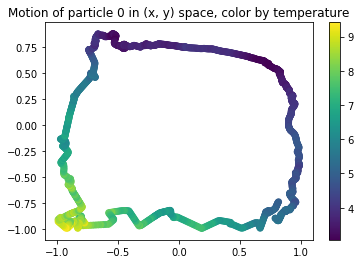

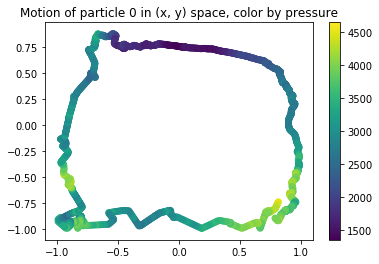

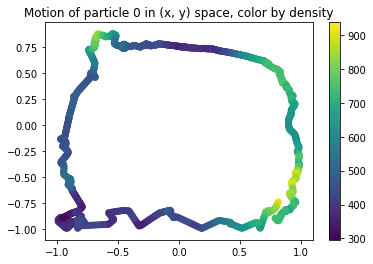

In [255]:
# Plot temperature, pressure, density locally
plt.figure()
tt = range(X.shape[0] - 1700, X.shape[0])
plt.scatter(X[tt, i, 0], X[tt, i, 1], c=[local_temperature(i, t) for t in tt])
plt.title(f'Motion of particle {i} in (x, y) space, color by temperature')
plt.colorbar();

plt.figure()
tt = range(X.shape[0] - 1700, X.shape[0])
plt.scatter(X[tt, i, 0], X[tt, i, 1], c=[local_pressure(i, t) for t in tt])
plt.title(f'Motion of particle {i} in (x, y) space, color by pressure')
plt.colorbar();

plt.figure()
tt = range(X.shape[0] - 1700, X.shape[0])
plt.scatter(X[tt, i, 0], X[tt, i, 1], c=[local_density(i, t) for t in tt])
plt.title(f'Motion of particle {i} in (x, y) space, color by density')
plt.colorbar();

## NOTE: Temperature seems to clearly be one of the state variables.
# What is the other? Pressure and density do not seem to be very good..
# Is it because of boundary effects?

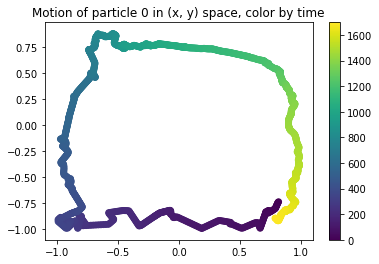

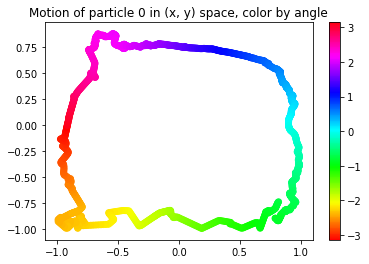

In [256]:
# Isolate one cycle manually
plt.figure()
tt = range(X.shape[0] - 1700, X.shape[0])
plt.scatter(X[tt, i, 0], X[tt, i, 1], c=range(len(tt)))
plt.title(f'Motion of particle {i} in (x, y) space, color by time')
plt.colorbar();

plt.figure()
tt = range(X.shape[0] - 1700, X.shape[0])
plt.scatter(X[tt, i, 0], X[tt, i, 1], c=np.arctan2(X[tt, i, 1], X[tt, i, 0]), cmap=plt.get_cmap('hsv'))
plt.title(f'Motion of particle {i} in (x, y) space, color by angle')
plt.colorbar();

Text(0.5,1,'color = angle of particle')

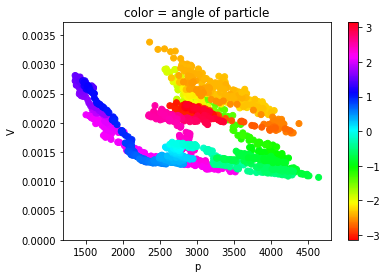

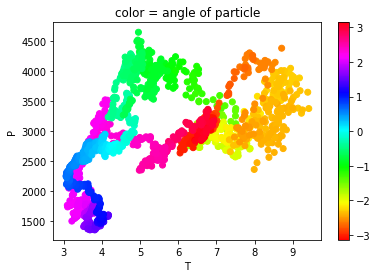

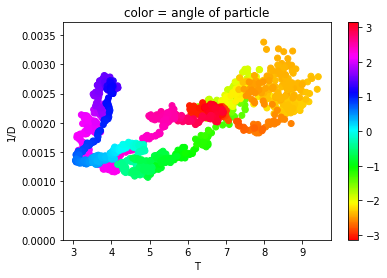

In [257]:
# Plot over time (subsection)
plt.scatter(P[tt], 1/D[tt], c=np.arctan2(X[tt, i, 1], X[tt, i, 0]), cmap=plt.get_cmap('hsv'));
plt.ylim([0, np.max(1/D[tt]) * 1.1]);
plt.xlabel('p');
plt.ylabel('V');
plt.colorbar();
plt.title('color = angle of particle')

# Plot over time (subsection)
plt.figure()
plt.scatter(T[tt], P[tt], c=np.arctan2(X[tt, i, 1], X[tt, i, 0]), cmap=plt.get_cmap('hsv'));
#plt.ylim([0, np.max(1/D[tt]) * 1.1]);
plt.xlabel('T');
plt.ylabel('P');
plt.colorbar();
plt.title('color = angle of particle')

# Plot over time (subsection)
plt.figure()
plt.scatter(T[tt], 1/D[tt], c=np.arctan2(X[tt, i, 1], X[tt, i, 0]), cmap=plt.get_cmap('hsv'));
plt.ylim([0, np.max(1/D[tt]) * 1.1]);
plt.xlabel('T');
plt.ylabel('1/D');
plt.colorbar();
plt.title('color = angle of particle')

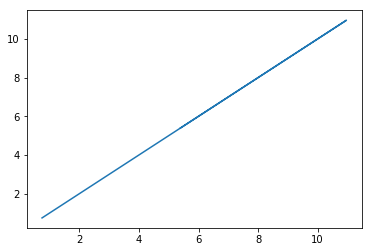

In [258]:
# The above shows an equation of type PV = aT, like an ideal gas
# The relationship holds (it better be, as it was computed that way), but no sign of an engine with cycles
plt.plot(P*1/D, T)

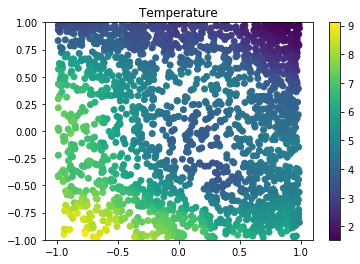

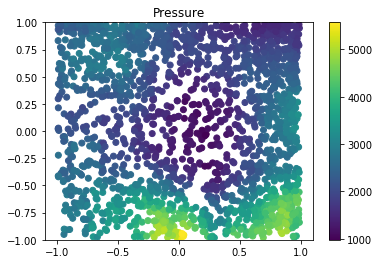

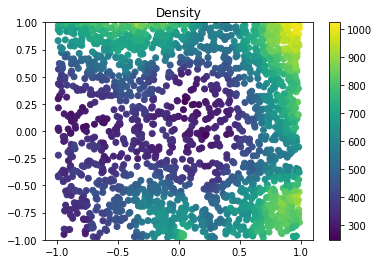

In [259]:
# Try to plot local temperature of fluid at a given time
t = int(0.7 * X.shape[0]) - 1
plt.scatter(X[t, :, 0], X[t, :, 1], c=[local_temperature(i, t) for i in range(X.shape[1])])
plt.ylim([-1, 1])
plt.title('Temperature')
plt.colorbar()

# Try to plot local pressure of fluid at a given time
plt.figure()
plt.scatter(X[t, :, 0], X[t, :, 1], c=[local_pressure(i, t) for i in range(X.shape[1])])
plt.ylim([-1, 1])
plt.title('Pressure')
plt.colorbar()

# Try to plot local density of fluid at a given time
plt.figure()
plt.scatter(X[t, :, 0], X[t, :, 1], c=[local_density(i, t) for i in range(X.shape[1])])
plt.ylim([-1, 1])
plt.title('Density')
plt.colorbar();

Text(0,0.5,'Tdot')

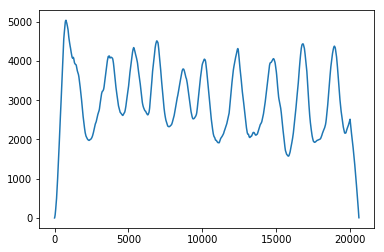

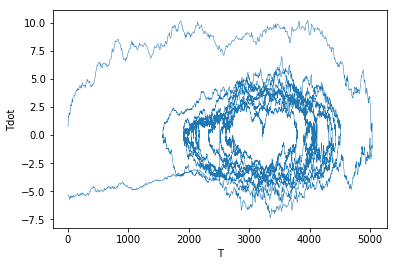

In [260]:
Tsmooth = np.convolve(T, np.ones(600))
plt.plot(Tsmooth)
plt.figure()
plt.plot(Tsmooth[1:], np.diff(Tsmooth), '-', linewidth=0.5)
plt.xlabel('T')
plt.ylabel('Tdot')

In [261]:
# Cycles can be identified as temperature cycles